# 課題のソースコード

##必要なライブラリ・データセットのインポート

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

In [3]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

### datasetの中身を確認。

In [4]:
from nltk.corpus import brown as corpus

In [5]:
print('ファイル数:',len(corpus.fileids()))
print('カテゴリ数:',len(corpus.categories()))
print('単語数:', len(corpus.words()))
print('文数:', len(corpus.sents()))

ファイル数: 500
カテゴリ数: 15
単語数: 1161192
文数: 57340


In [6]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:300]):
    print(item, end=" ")
    if (n%25) ==24:
      print(" ")

The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .  
The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise  
and thanks of the City of Atlanta '' for the manner in which the election was conducted . The September-October term jury had been charged  
by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan  
Allen Jr. . `` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in  
the election , the number of voters and the size of this city '' . The jury said it did find that many of Georgia's  
registration and election laws `` are outmoded or inadequate and often ambiguous '' . It recommended that Fulton legislators act `

### 全documentで学習する

In [7]:
corpus.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [8]:
docs=[corpus.words(fileid) for fileid in corpus.fileids()]
labels=[corpus.categories(fileid) for fileid in corpus.fileids()]

## 前処理編

### nltkのストップワードリスト

In [9]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<","''", ""] \
         +en_stop

### 前処理関数の作成

In [10]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport
import re

def preprocess_word(word, stopwordset):

    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def cleaning_text(text):
    pattern1 = '@'
    text = re.sub(pattern1, '', text)    
    pattern2 = '<b>|</b>' 
    text = re.sub(pattern2, '', text)    
    pattern3 = '\(.*?\)'
    text = re.sub(pattern3, '', text)
    pattern4 = '\<.*?\>'
    text = re.sub(pattern4, '', text)
    pattern5 = '[0-9]*'
    text = re.sub(pattern5, '', text)
    return text

def preprocess_document(document):
    document=[cleaning_text(text) for text in document] 
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    documents = [preprocess_document(document) for document in documents]
    return documents 

### 前処理の結果を出力

### 前処理前

In [11]:
print(docs[0][:25]) 

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


### 前処理後

In [12]:
print(preprocess_documents(docs)[0][:25])

['fulton', 'county', 'grand', 'jury', 'say', 'friday', 'investigation', "atlanta's", 'recent', 'primary', 'election', 'produce', 'evidence', 'irregularity', 'take', 'place', 'jury', 'say', 'term-end', 'presentment', 'city', 'executive', 'committee', 'over-all', 'charge']


## クラスタリング編

### tf idfで上記の前処理済みの文章をベクトル化
### vectorizerを使用する（ハイパーパラメーターの設定）

In [13]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\\b\\w+\\b' )

fulton county grand jury say friday investigation atlanta's recent primary election produce evidence irregularity take place jury say term-end presentment city executive committee over-all charge election deserve praise thanks city atlanta manner election conduct september-october term jury charge fulton superior court judge durwood pye investigate report possible irregularity hard-fought primary mayor-nominate ivan allen jr. relative handful report receive jury say consider widespread interest election number voter size city jury say find many georgia's registration election laws outmode inadequate often ambiguous recommend fulton legislator act laws study revise end modernize improve grand jury comment number topic among atlanta fulton county purchasing department say well operate follow generally accept practice inure best interest government merger propose however jury say belief two office combine achieve greater efficiency reduce cost administration city purchasing department jur

### fitする

In [14]:
tf_idf = vectorizer.fit_transform(pre_docs)

### K-means

In [15]:
def show_labels(pre_docs, clusters, labels):
  i = 0
  pre_label = ""
  for doc, cls, label in zip(pre_docs, clusters, labels):
      if label != pre_label:
        print(label, cls, doc[0:100])
        i += 1
        if i % 5 == 0:
          pre_label = label

def show(clusters):
  num_cluster = len(set(clusters))
  print(num_cluster)
  plt.hist(clusters, bins = num_cluster)
  plt.xlabel("label")
  plt.ylabel("count")
  plt.title("Histogram of k-means")
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15


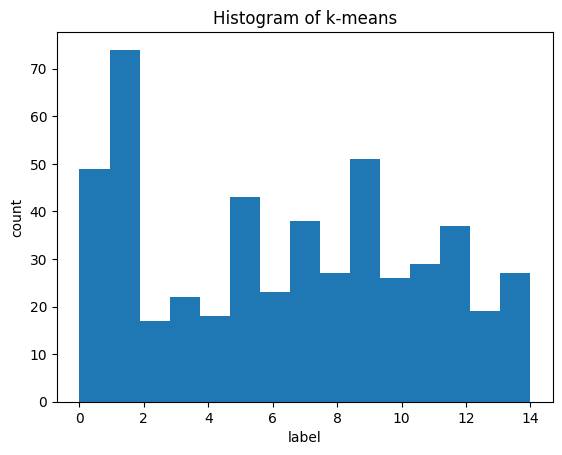

In [16]:
km_15 = KMeans(n_clusters=15, random_state = 0)
clusters_15 = km_15.fit_predict(tf_idf)
show(clusters_15)

5


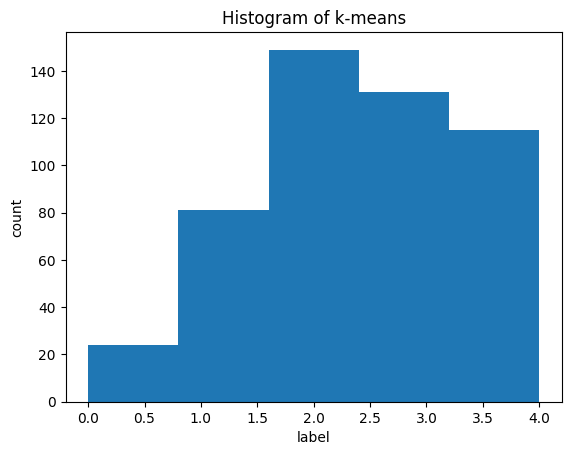

In [17]:
km_5 = KMeans(n_clusters=5, random_state = 0)
clusters_5 = km_5.fit_predict(tf_idf)
show(clusters_5)

In [18]:
show_labels(pre_docs, clusters_15, labels)

['news'] 1 fulton county grand jury say friday investigation atlanta's recent primary election produce evidence
['news'] 13 austin texas committee approval gov. price daniel's abandon property act seem certain thursday despi
['news'] 8 several defendant summerdale police burglary trial make statement indicate guilt time arrest judge j
['news'] 10 oslo positive element emerge oslo meeting north atlantic treaty organization foreign minister free f
['news'] 11 east providence organize civil defense setup begin appoint full-time director raymond h. hawksley pr
['editorial'] 10 assembly session bring much good general assembly adjourn today perform atmosphere crisis struggle d
['editorial'] 11 must berlin remain divide inference widely accept communist succeed building barricade across berlin
['editorial'] 11 good man depart goodby mr. sam sam rayburn good man good american third good democrat roll one sturd
['editorial'] 7 shock wave africa word dag hammarskjold's death african plane crash

In [19]:
show_labels(pre_docs, clusters_5, labels)

['news'] 1 fulton county grand jury say friday investigation atlanta's recent primary election produce evidence
['news'] 1 austin texas committee approval gov. price daniel's abandon property act seem certain thursday despi
['news'] 1 several defendant summerdale police burglary trial make statement indicate guilt time arrest judge j
['news'] 1 oslo positive element emerge oslo meeting north atlantic treaty organization foreign minister free f
['news'] 1 east providence organize civil defense setup begin appoint full-time director raymond h. hawksley pr
['editorial'] 3 assembly session bring much good general assembly adjourn today perform atmosphere crisis struggle d
['editorial'] 1 must berlin remain divide inference widely accept communist succeed building barricade across berlin
['editorial'] 1 good man depart goodby mr. sam sam rayburn good man good american third good democrat roll one sturd
['editorial'] 1 shock wave africa word dag hammarskjold's death african plane crash sent 

In [20]:
def cosine_similarity(list_a, list_b):
  inner_prod = np.array(list_a).dot(np.array(list_b))
  norm_a = np.linalg.norm(list_a)
  norm_b = np.linalg.norm(list_b)
  try:
      return inner_prod / (norm_a*norm_b)
  except ZeroDivisionError:
      return 1.0

def calc_cosine(vector, vector_list):
  result = {}
  for i, x in enumerate(vector_list):
    result[i] = cosine_similarity(vector, vector_list[i])
    
  return result

print("tfidf")
tfidf_vector = tf_idf.toarray()
res = calc_cosine(tfidf_vector[0],tfidf_vector)
sorted(res.items(), key=lambda x:x[1],reverse=True)

tfidf


[(0, 1.0000000000000002),
 (8, 0.691301646490901),
 (5, 0.6786851591726192),
 (1, 0.6715100764750268),
 (18, 0.6445744537987301),
 (19, 0.6166988689139633),
 (21, 0.6128946461727383),
 (4, 0.5990470152581756),
 (496, 0.5903110344749325),
 (26, 0.5838316965557697),
 (233, 0.5783714797067773),
 (20, 0.5777698793399675),
 (205, 0.5701363849164015),
 (186, 0.5693300654136859),
 (222, 0.5691602610232509),
 (495, 0.5689529409129611),
 (9, 0.5643156446369565),
 (465, 0.5631120930990797),
 (50, 0.5595285813610206),
 (23, 0.5589853283096908),
 (24, 0.5551823683459349),
 (82, 0.5550814750659038),
 (392, 0.55268276330017),
 (374, 0.5491198248360889),
 (220, 0.548691005121552),
 (228, 0.5476632875655633),
 (39, 0.5460558904318772),
 (255, 0.545851703743664),
 (476, 0.5446916864694261),
 (456, 0.540536593927341),
 (36, 0.5391244435629671),
 (57, 0.5381598596779092),
 (468, 0.536739571740742),
 (164, 0.5306502225432131),
 (226, 0.5293167423070595),
 (428, 0.528955618330536),
 (463, 0.523021949312559

In [21]:
print(labels[0], pre_docs[0])
print(labels[8], clusters_15[8], clusters_5[8], pre_docs[8])

['news'] fulton county grand jury say friday investigation atlanta's recent primary election produce evidence irregularity take place jury say term-end presentment city executive committee over-all charge election deserve praise thanks city atlanta manner election conduct september-october term jury charge fulton superior court judge durwood pye investigate report possible irregularity hard-fought primary mayor-nominate ivan allen jr. relative handful report receive jury say consider widespread interest election number voter size city jury say find many georgia's registration election laws outmode inadequate often ambiguous recommend fulton legislator act laws study revise end modernize improve grand jury comment number topic among atlanta fulton county purchasing department say well operate follow generally accept practice inure best interest government merger propose however jury say belief two office combine achieve greater efficiency reduce cost administration city purchasing depar